In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob

In [2]:
def camera_cal(img, nx, ny):
    
    # To map the coordinates of the corners in the 2D image (img in this case) called imgpoints to the 3D coordinates 
    # of the real, undistorted chessboard corners called objpoint
    
    imgpoints = [] # 2D coordinates in image plane    
    objpoints = [] # 3D coordinates in real world space

    
    objp = np.zeros((ny*nx, 3), np.float32)  # (54, 3) 54 points each with 3 columns for the x, y, z coordinates of each corner
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # (54, 3) They are filled as (0.,0.,0.), (1.,0.,0.), (2.,0.,0.) ..... (8.,5.,0.)
    
    for image_name in (images):
        image_original = mpimg.imread(image_name)

        # Convert to grayscale
        gray = cv2.cvtColor(image_original, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # corners = Output array of detected corners. The values returned for first corner of the first image are:
        # [545.3228  343.05032] which is [nx ny]

        # If found, draw corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            image_corner = np.copy(image_original)
            cv2.drawChessboardCorners(image_corner, (nx, ny), corners, ret)

            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
            ax1.imshow(image_original)
            ax1.set_title('image_original', fontsize=15)
            ax2.imshow(image_corner)
            ax2.set_title('image_corner', fontsize=15)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) # gray.shape[::-1] reverses shape from (720, 1280) to (1280, 720)
    # ret = 1.0298149716172809
    # mtx = [[1.15777818e+03 0.00000000e+00 6.67113857e+02]
    #        [0.00000000e+00 1.15282217e+03 3.86124583e+02]
    #        [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
    # dist = [k1, k2, p1, p2, k3] -> [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]
    
    # dist = distortion coefficients
    # mtx = camera matrix that we need to transform 3D object points to 2D image points
    # rvecs (rotation vector), tvecs (translation vector) = denotes position of the camera in the world
    return mtx, dist

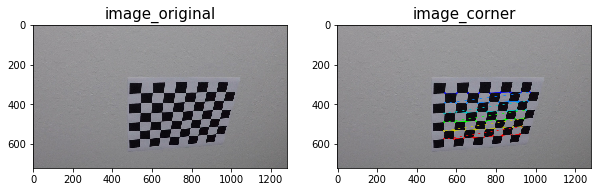

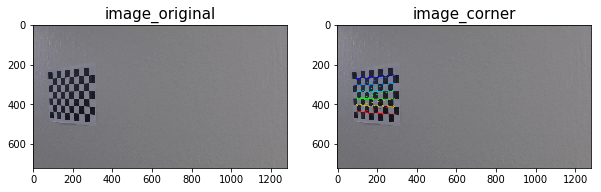

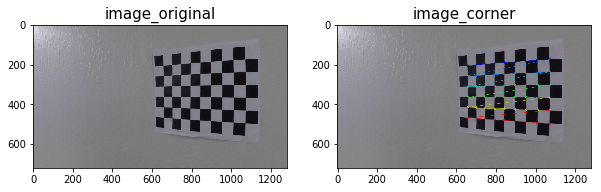

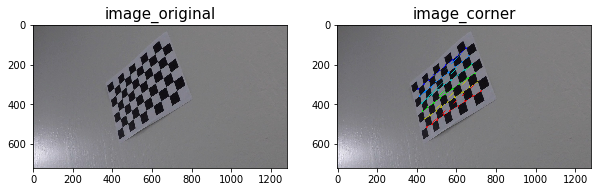

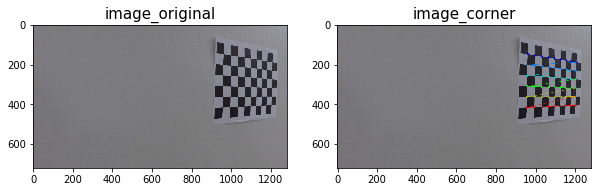

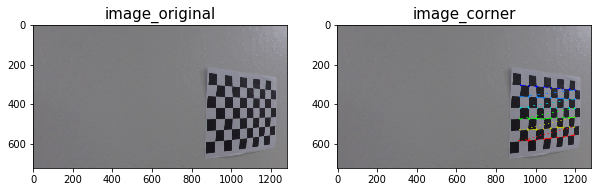

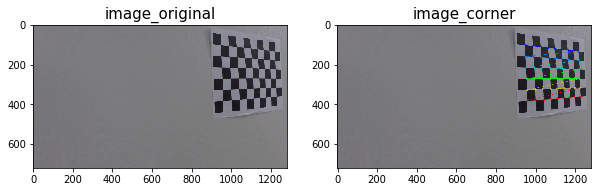

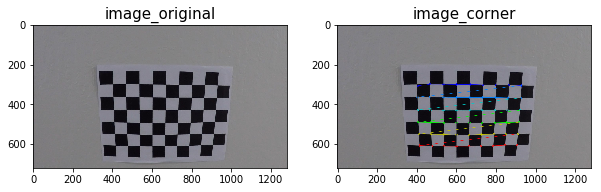

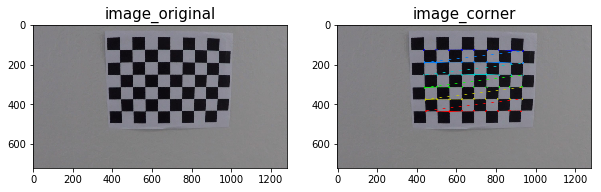

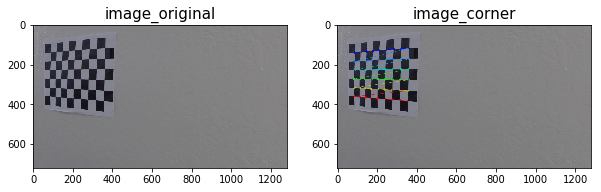

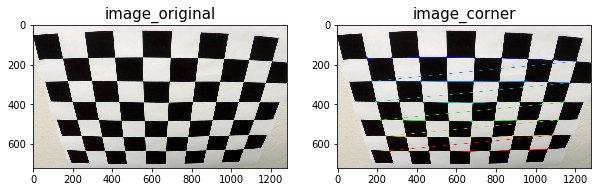

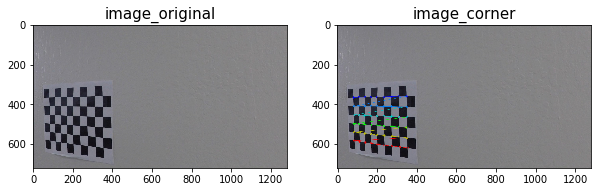

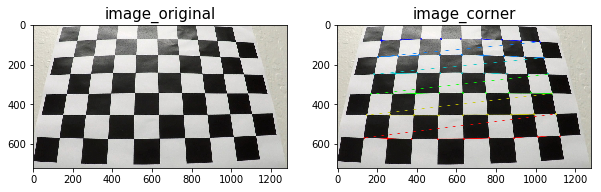

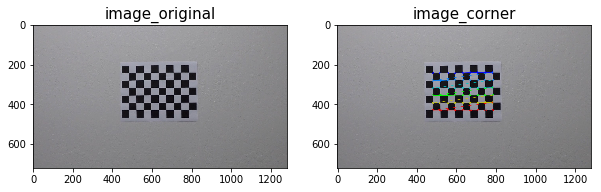

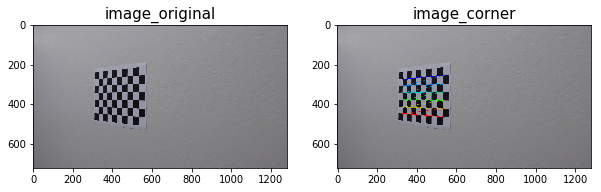

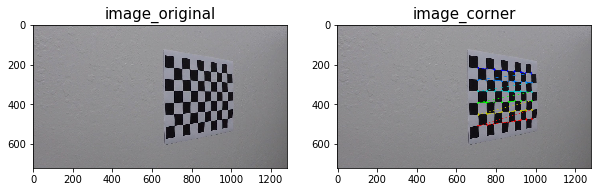

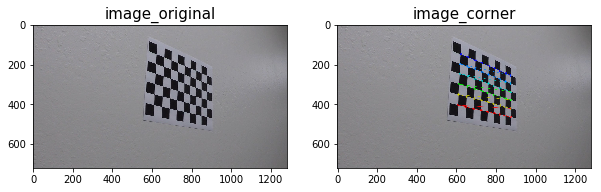

In [3]:
cam_folder = 'camera_cal/'
nx = 9 #enter the number of inside corners in x
ny = 6 #enter the number of inside corners in y

images = glob(cam_folder + '/*.jpg')
mtx, dist = camera_cal(images, nx, ny)

In [4]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [5]:
def warp_chessboard(undist, nx, ny):
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0][0], corners[nx - 1][0], corners[-1][0], corners[-nx][0]])
        # print(corners[0][0])                    [710.3549 215.566 ]
        dst = np.float32([[100, 100], [1180,100], [1180, 620], [100, 620]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
        
    return warped, M

Text(0.5, 1.0, 'undistorted & warped')

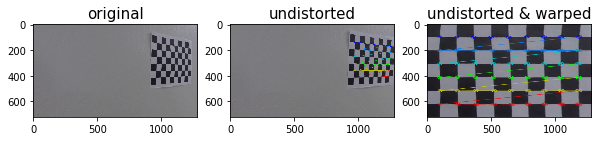

In [6]:
img = mpimg.imread(np.random.choice(images))
undist = undistort(img, mtx, dist)

# A perspective transforms the z coordinate of the object point which in turn changes the object's 2D image representation
# It warps the image & drags points towards or away from camera to change apparent perspective
# For a bird's eye view, we can apply perspective transform. This helps in fiding curvature of lane. It's also helps in 
# matching car's location directly with the map (displays from bird's eye view)

# Select 4 source points that define a rectangle on the source image
# Select 4 destination points on the warped image where you want the 4 source points to appear
# Use opencv to calculate the transform 'M' that maps source points onto destination points
# Apply transform 'M' to the original image to get the warped image using opencv
top_down, perspective_M = warp_chessboard(undist, nx, ny)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 20))
ax1.imshow(img)
ax1.set_title('original', fontsize=15)
ax2.imshow(undist)
ax2.set_title('undistorted', fontsize=15)
ax3.imshow(top_down)
ax3.set_title('undistorted & warped', fontsize=15)

In [7]:
def warp_test_images(img):
    
    src = np.float32([[480, 480],[800, 480],
                      [1250, 720],[50, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1280, 720],[0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.shape[1::-1])
    
    return warped, M

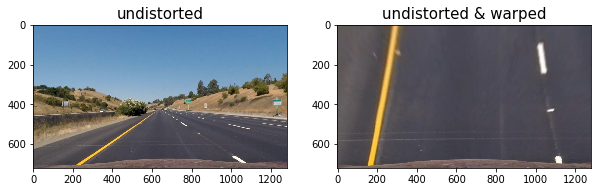

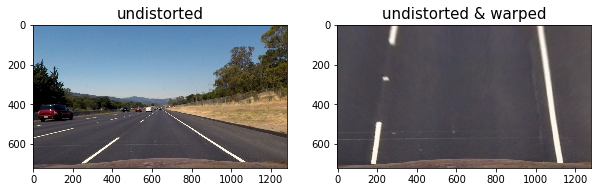

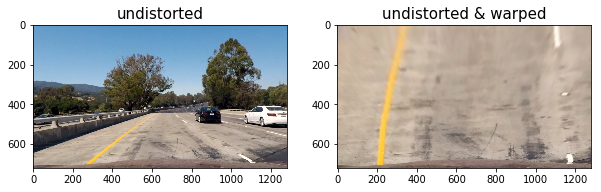

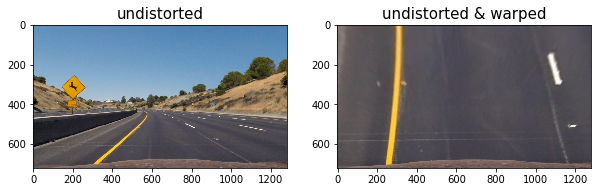

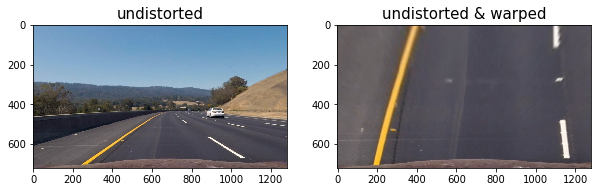

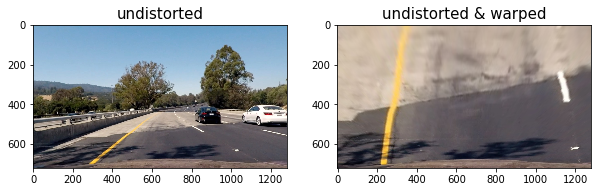

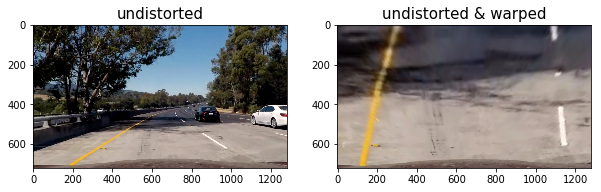

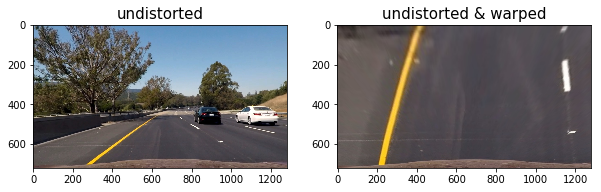

In [8]:
input_folder = 'test_images/'

for img in glob(input_folder + '/*.jpg'):
    img = mpimg.imread(img)
    undist = undistort(img, mtx, dist)
    top_down, perspective_M = warp_test_images(undist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
    ax1.imshow(undist)
    ax1.set_title('undistorted', fontsize=15)
    ax2.imshow(top_down)
    ax2.set_title('undistorted & warped', fontsize=15)